# EMOTION CLASSIFICATION
## Name: Mia Truong, Hui Xie

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Prepare Data

In [ ]:
# Load the data
emotion_data = pd.read_csv('Neuros2_emotions.csv')

In [ ]:
# Split features and targets
X = emotion_data.drop(columns=['label'])
y = emotion_data['label']

In [ ]:
# Encode categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
labels = label_encoder.classes_

### Visualize example data for each label

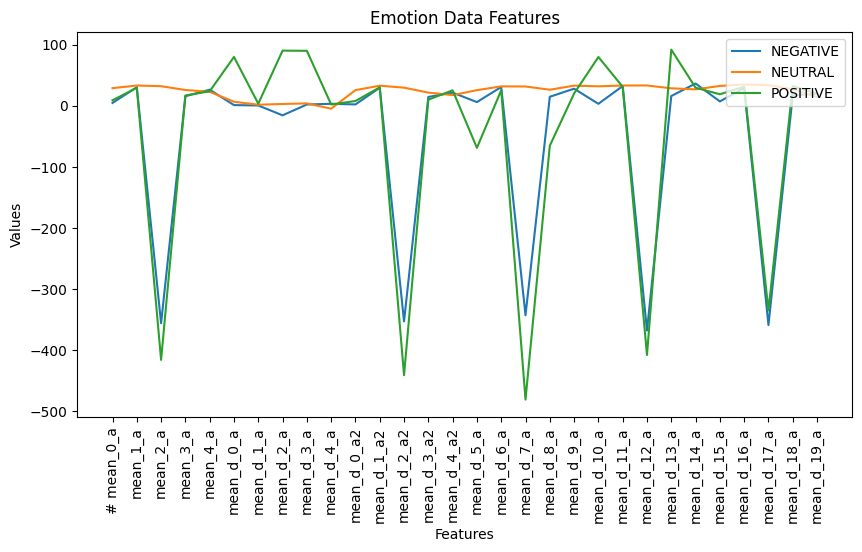

In [ ]:
# Select a subset of the data to visualize
num_features_to_plot = 30  # Number of features to plot
sample_size_per_label = 1  # Number of samples per label

plt.figure(figsize=(10, 5))

# Track which labels have been plotted
plotted_labels = set()

# Plot examples for each label
for label in labels:
    subset = emotion_data[emotion_data['label'] == label].head(sample_size_per_label)
    for index, row in subset.iterrows():
        plt.plot(X.columns[:num_features_to_plot], row[:num_features_to_plot], label=label if label not in plotted_labels else "")
        plotted_labels.add(label)

plt.title('Emotion Data Features')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Values')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [ ]:
print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

# Print some samples to verify
print("Train samples:", y_train[:5])
print("Validation samples:", y_val[:5])
print("Test samples:", y_test[:5])


Train shape: (1705, 2548) (1705,)
Validation shape: (213, 2548) (213,)
Test shape: (214, 2548) (214,)
Train samples: [0 1 1 1 2]
Validation samples: [2 1 2 2 1]
Test samples: [0 0 2 1 1]


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Define Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        output, hidden = self.gru(x)
        output = self.dropout(output)
        return hidden

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate):
        super(Decoder, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, hidden):
        output, hidden = self.gru(x, hidden)
        output = self.dropout(output)
        prediction = self.fc(output)
        return prediction, hidden

class EncoderDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate):
        super(EncoderDecoder, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers, dropout_rate)
        self.decoder = Decoder(input_size, hidden_size, output_size, num_layers, dropout_rate)

    def forward(self, x):
        encoder_hidden = self.encoder(x)
        prediction, _ = self.decoder(x, encoder_hidden)
        return prediction

In [ ]:
# Define Hyperparameters
input_size = X_train_scaled.shape[1]
hidden_size = 128
output_size = len(np.unique(y_encoded))
num_layers = 2
dropout_rate = 0.5  # Adding dropout rate
learning_rate = 0.0015
weight_decay = 0.05  # Adding weight decay for L2 regularization
num_epochs = 20
batch_size = 16

In [ ]:
# Create model, criterion, and optimizer
model = EncoderDecoder(input_size, hidden_size, output_size, num_layers, dropout_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader for batch processing
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Training Loop

In [ ]:
# Track training and validation loss
train_loss_list = []
val_loss_list = []


In [ ]:
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(0)).squeeze(0)
        loss = criterion(outputs, targets)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss_list.append(epoch_train_loss / len(train_loader))
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor.unsqueeze(0)).squeeze(0)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_loss_list.append(val_loss.item())
        
    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss / len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}')

Epoch 1, Train Loss: 0.3947, Val Loss: 0.3199
Epoch 2, Train Loss: 0.2912, Val Loss: 0.2832
Epoch 3, Train Loss: 0.2935, Val Loss: 0.3071
Epoch 4, Train Loss: 0.2951, Val Loss: 0.2933
Epoch 5, Train Loss: 0.2845, Val Loss: 0.5642
Epoch 6, Train Loss: 0.2994, Val Loss: 0.2738
Epoch 7, Train Loss: 0.2848, Val Loss: 0.3066
Epoch 8, Train Loss: 0.2815, Val Loss: 0.3142
Epoch 9, Train Loss: 0.3018, Val Loss: 0.3283
Epoch 10, Train Loss: 0.3005, Val Loss: 0.3557
Epoch 11, Train Loss: 0.2862, Val Loss: 0.3310
Epoch 12, Train Loss: 0.2930, Val Loss: 0.3287
Epoch 13, Train Loss: 0.2840, Val Loss: 0.3111
Epoch 14, Train Loss: 0.2920, Val Loss: 0.3368
Epoch 15, Train Loss: 0.2880, Val Loss: 0.3304
Epoch 16, Train Loss: 0.2888, Val Loss: 0.2836
Epoch 17, Train Loss: 0.2740, Val Loss: 0.3189
Epoch 18, Train Loss: 0.2844, Val Loss: 0.3002
Epoch 19, Train Loss: 0.2852, Val Loss: 0.2908
Epoch 20, Train Loss: 0.2897, Val Loss: 0.3013


## Model Evaluation

In [ ]:
# Model evaluation on the validation set
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor.unsqueeze(0)).squeeze(0)
    _, val_predicted = torch.max(val_outputs, 1)
    val_accuracy = (val_predicted == y_val_tensor).float().mean().item()
    print(f'Validation Accuracy: {val_accuracy:.2f}')

# Model evaluation on the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor.unsqueeze(0)).squeeze(0)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = (test_predicted == y_test_tensor).float().mean().item()
    print(f'Test Accuracy: {test_accuracy:.2f}')


Validation Accuracy: 0.91
Test Accuracy: 0.92


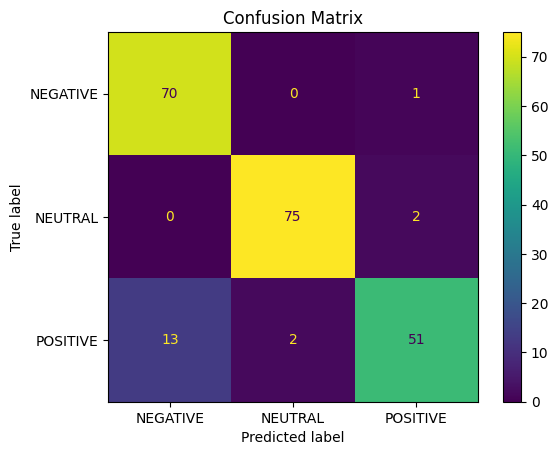

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_tensor.cpu(), test_predicted.cpu())
cmd = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
cmd.plot()
plt.title('Confusion Matrix')
plt.show()

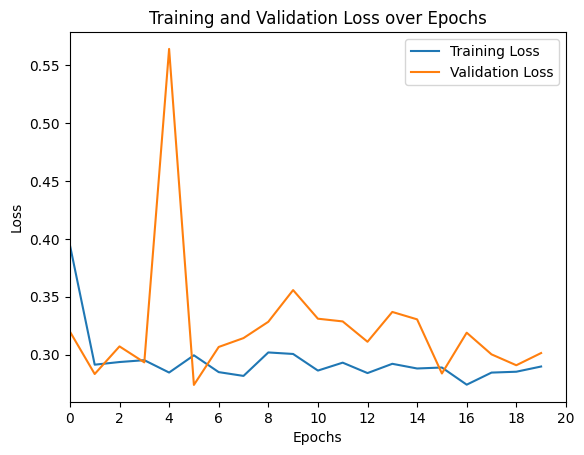

In [ ]:
# Visualize the training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.xlim(0, 20)
plt.xticks(range(0, 21, 2))
plt.show()